# 사용법
0. (선택사항 : 개인 디렉토리에 코드와 csv 파일을 복사한다.)
1. 같은 /test 디렉토리 안에 output.csv 파일을 넣는다
2. 아래 코드를 실행한다.

출력창에 예측률, 얼마나 맞추고 틀렸나를 matrix, 시계열 꼴로 보여줌

combined_btc_usd_historical_data.csv 데이터는 거래소별로 BTC/USD값을 가져올수 있는만큼 가져와서 평균낸값임.

In [ ]:
# 패키지 없으면 다운로드용
!pip install pandas numpy scikit-learn matplotlib seaborn

Columns in merged_df: Index(['datetime', 'target_x', 'ID', 'target_y'], dtype='object')
Confusion Matrix:
[[  7  29 287   7]
 [  2 223 794   5]
 [  3 477 569   6]
 [  6 247 123   7]]

Accuracy: 0.2887


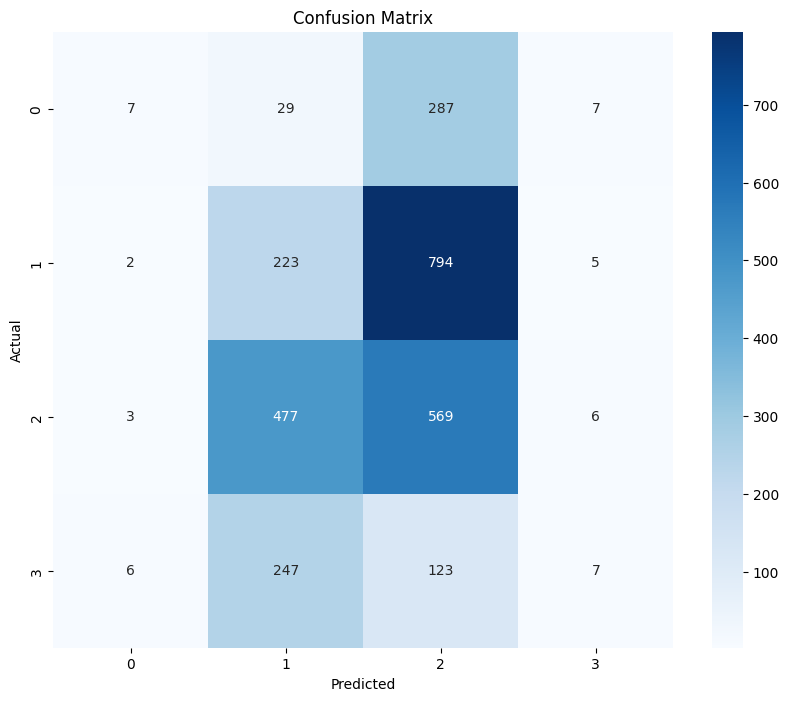

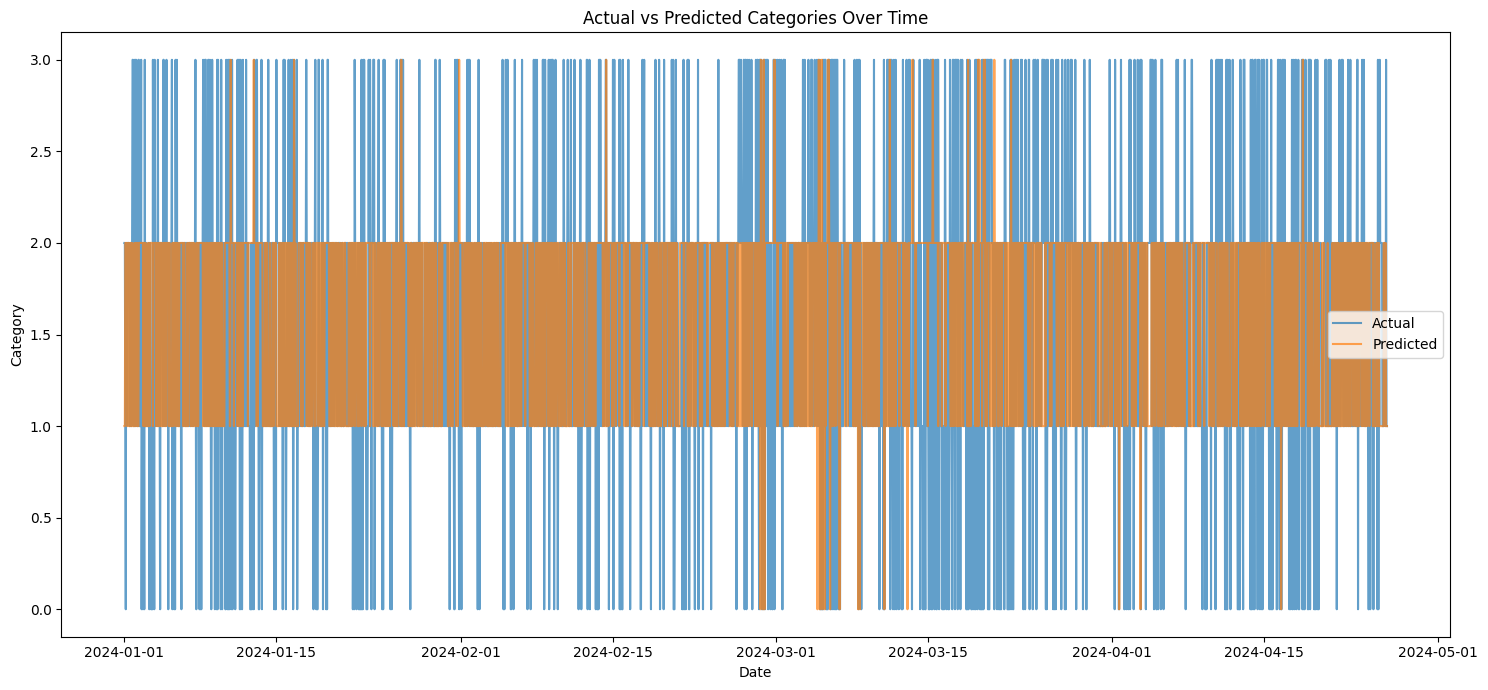

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("combined_btc_usd_historical_data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])

df = df[df["datetime"]>="2023-12-31 23:00:00"]
df = df[df["datetime"]<="2024-04-26 07:00:00"]

def categorize_change(pct_change):
    if pct_change < -0.005:
        return 0
    elif -0.005 <= pct_change < 0:
        return 1
    elif 0 <= pct_change < 0.005:
        return 2
    else:
        return 3

df['pct_change'] = df['average'].pct_change()
df['target'] = df['pct_change'].apply(categorize_change)
df_eval = df[(df["datetime"] >= "2024-01-01 00:00:00") & (df["datetime"] <= "2024-04-26 07:00:00")]

# output.csv 읽기
output_df = pd.read_csv("output.csv")
output_df["ID"] = pd.to_datetime(output_df["ID"])

# 두 데이터프레임 병합
merged_df = pd.merge(df_eval[['datetime', 'target']], output_df, left_on='datetime', right_on='ID', how='inner')

if 'target_x' in merged_df.columns and 'target_y' in merged_df.columns:
    actual_col = 'target_x'
    predicted_col = 'target_y'
elif 'target' in merged_df.columns and 'target_y' in merged_df.columns:
    actual_col = 'target'
    predicted_col = 'target_y'
else:
    raise ValueError("Unexpected column names after merging")

cm = confusion_matrix(merged_df[actual_col], merged_df[predicted_col])

accuracy = accuracy_score(merged_df[actual_col], merged_df[predicted_col])
############################################################################################
print(f"\nAccuracy: {accuracy:.4f}")
############################################################################################
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.close()
############################################################################################
plt.figure(figsize=(15, 7))
plt.plot(merged_df['datetime'], merged_df[actual_col], label='Actual', alpha=0.7)
plt.plot(merged_df['datetime'], merged_df[predicted_col], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Categories Over Time')
plt.xlabel('Date')
plt.ylabel('Category')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()